In [11]:
!pip install timm==0.4.12
# TODO: Upload or clone models/swin_transformer_v2.py
!mkdir models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 0.9.7
    Uninstalling timm-0.9.7:
      Successfully uninstalled timm-0.9.7


mkdir: cannot create directory ‘models’: File exists


In [1]:
import torch
import torch.nn.functional as F
import math
from PIL import Image
from torchvision import transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.data.transforms import _pil_interp
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import numpy as np
from torchvision import datasets
from torch.utils import data
import cv2
from google.colab.patches import cv2_imshow

In [5]:
from models.swin_transformer_v2 import SwinTransformerV2

In [6]:
IMG_SIZE = 96
INTERPOLATION = 'bicubic'
to_img = ToPILImage()

In [7]:
num_classes = 2
model = SwinTransformerV2(
    img_size=256,
    patch_size=[4, 4],
    embed_dim=128,
    depths=[2, 2, 18, 2],
    num_heads=[4, 8, 16, 32],
    window_size=8,
    stochastic_depth_prob=0.5,
    num_classes=num_classes
)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# load checkpoint
checkpoint_path = "/content/drive/MyDrive/AI for Medical Imaging/Models_weights/SwinTransformerV2_lr01_epoch10_augment/SwinTransformerV2.pt"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [10]:
def build_transform_test():
    t = []
    size = 256
    t.append(
        transforms.Resize(size, interpolation=_pil_interp(INTERPOLATION)),
        # to maintain same ratio w.r.t. 224 images
    )
    # t.append(transforms.CenterCrop(224))

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))
    return transforms.Compose(t)

def init_image(image_path):
    transform = build_transform_test()
    img = Image.open(image_path)
    img = img.convert("RGB")
    img = transform(img)
    img = img.unsqueeze(0)
    return img

In [33]:
def draw_grad_cam(model, image_path, activation_class, out_path='img.jpg'):
  model.eval()
  image = init_image(image_path)
  outs, _ = model(image)
  softmax = torch.nn.Softmax(dim=1)
#   print("outs", outs)
#   out = softmax(outs)
  out = outs
  print(out)
  # outs[class_num][0][activation_class].backward()  # '0' for batch, activation_class -> 1 for positive activation 0 for negative
  out[0][activation_class].backward()  # '0' for batch, activation_class -> 1 for positive activation 0 for negative
  gradients = model.get_activations_gradient()
  # print(gradients.shape)
  pooled_gradients = torch.mean(gradients, dim=[0, 1, 2])
  activations = model.get_activations()   # can put extra .detach
  # print(pooled_gradients.shape)
#   print(activations.shape)
  for i in range(activations.shape[-1]):
    activations[:, :, :, i] *= pooled_gradients[i]
  heatmap = torch.mean(activations, dim=3).squeeze()
  heatmap = np.maximum(heatmap, 0)
  heatmap /= torch.max(heatmap)
  # plt.matshow(heatmap.squeeze())
  img = cv2.imread(image_path, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (256, 256))
#   img = img[16:240, 16:240]
  # print(img.shape)
  # print(heatmap.shape)
  heatmap = cv2.resize(heatmap.detach().numpy(), (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * 0.4 + img
  cv2_imshow(superimposed_img)
  cv2.imwrite(out_path, superimposed_img)

tensor([[ 1.5752, -1.7017]], grad_fn=<AddmmBackward0>)


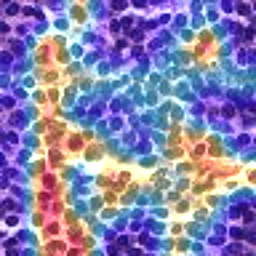

In [34]:
IMG_PATH = '/content/drive/MyDrive/PCAM imgs/img1.png'
draw_grad_cam(model, IMG_PATH, 0)

tensor([[ 1.5752, -1.7017]], grad_fn=<AddmmBackward0>)


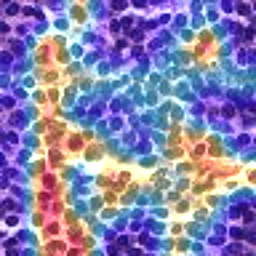

tensor([[ 1.5752, -1.7017]], grad_fn=<AddmmBackward0>)


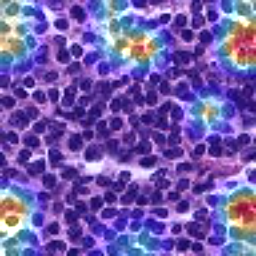

tensor([[-3.5426,  3.4383]], grad_fn=<AddmmBackward0>)


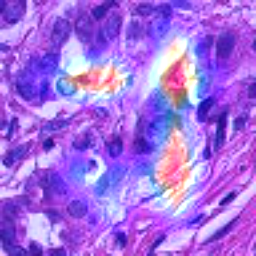

tensor([[-3.5426,  3.4383]], grad_fn=<AddmmBackward0>)


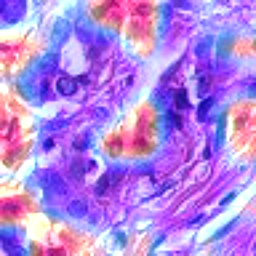

tensor([[-2.3683,  2.1794]], grad_fn=<AddmmBackward0>)


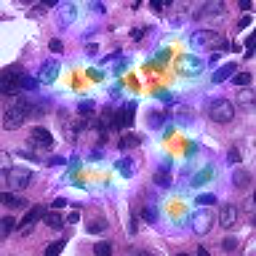

tensor([[-2.3683,  2.1794]], grad_fn=<AddmmBackward0>)


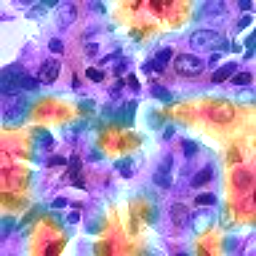

tensor([[-2.3710,  2.1313]], grad_fn=<AddmmBackward0>)


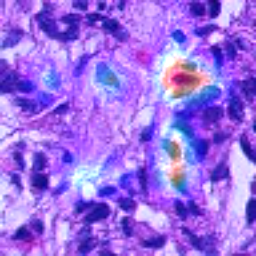

tensor([[-2.3710,  2.1313]], grad_fn=<AddmmBackward0>)


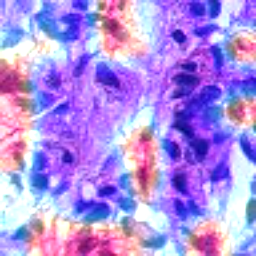

tensor([[ 0.6786, -0.6910]], grad_fn=<AddmmBackward0>)


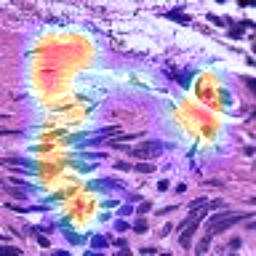

tensor([[ 0.6786, -0.6910]], grad_fn=<AddmmBackward0>)


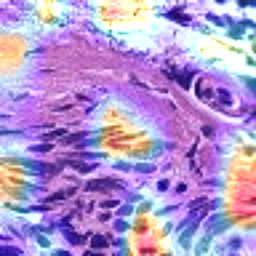

tensor([[ 3.5513, -3.9855]], grad_fn=<AddmmBackward0>)


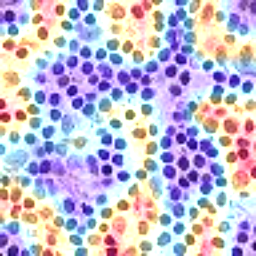

tensor([[ 3.5513, -3.9855]], grad_fn=<AddmmBackward0>)


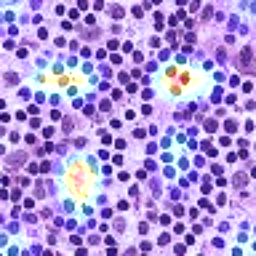

tensor([[-1.6758,  1.5398]], grad_fn=<AddmmBackward0>)


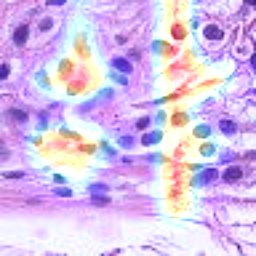

tensor([[-1.6758,  1.5398]], grad_fn=<AddmmBackward0>)


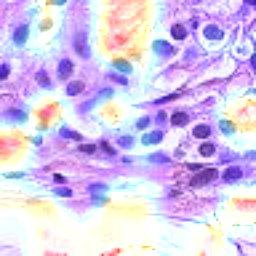

tensor([[-2.2461,  2.5170]], grad_fn=<AddmmBackward0>)


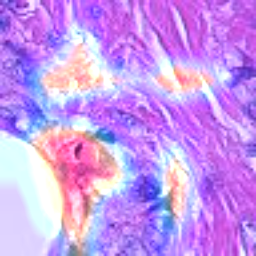

tensor([[-2.2461,  2.5170]], grad_fn=<AddmmBackward0>)


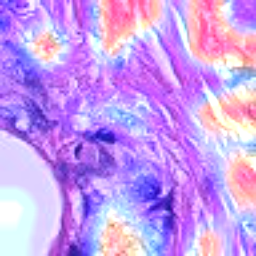

tensor([[-1.8584,  1.4187]], grad_fn=<AddmmBackward0>)


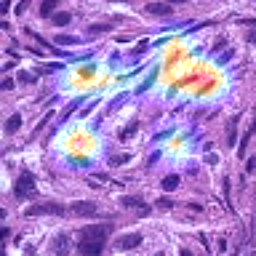

tensor([[-1.8584,  1.4187]], grad_fn=<AddmmBackward0>)


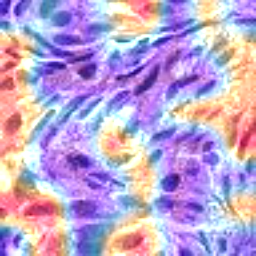

tensor([[ 0.6331, -0.9480]], grad_fn=<AddmmBackward0>)


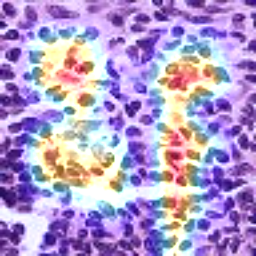

tensor([[ 0.6331, -0.9480]], grad_fn=<AddmmBackward0>)


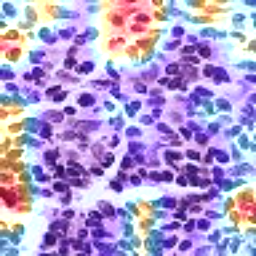

In [35]:
for i in range(1, 11):
    IMG_PATH = f'/content/drive/MyDrive/PCAM imgs/img{i}.png'.format(i)
    draw_grad_cam(model, IMG_PATH, 0, out_path=f'/content/drive/MyDrive/PCAM imgs/gradcam_results/img{i}_gradcam_0.png'.format(i))
    draw_grad_cam(model, IMG_PATH, 1, out_path=f'/content/drive/MyDrive/PCAM imgs/gradcam_results/img{i}_gradcam_1.png'.format(i))

In [36]:
# !cp -r /content/drive/MyDrive/PCAM\ imgs /content/drive/MyDrive/AI\ for\ Medical\ Imaging